In [1]:
import numpy as np
import pandas as pd

# Entrenamiento recsys con autoencoders

In [2]:
interactions_path = "data/ml-1m/ratings.dat"
model_path = "data/ml-1m/model.pth"

## Lectura y limpieza de los datos

Leemos el archivo `.dat` que contiene las interacciones usuario-película con los ratings, aunque como vamos a entrenar un modelo implícito solo nos interesa si han interactuado con la pélicula o no.

In [3]:
interactions = pd.read_csv(
    interactions_path, 
    sep="::", header = None, encoding = "ISO-8859-1",
    engine = "python"
)
interactions.columns = ["user_id", "item_id", "rating", "timestamp"]
interactions.head()

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Tanto `user_id` como `ìtem_id` están indexados a partir de `1`. Por comodidad los pasamos a que estén en base `0` simplemente restándoles `1`.

In [4]:
interactions.user_id = interactions.user_id - 1
interactions.item_id = interactions.item_id - 1

## Entrenamiento del modelo

Cargamos la libreria `torch` así como el módulo de codigo que contiene la definición de la arquitectura de autoencoder que vamos a usar.

In [5]:
import torch
import torch.nn as nn

from model.autoencoder import MovieLensAutoencoder
from model.callbacks import plot_callback

Convertimos el `DataFrame` a un tensor de pytorch que representa la matriz de interacciones con los usuarios por filas y las películas por columnas.

In [6]:
x = torch.sparse.FloatTensor(
    torch.LongTensor(np.transpose(interactions[["user_id", "item_id"]].values)),
    torch.FloatTensor(np.ones(interactions.shape[0]))
).to_dense()

Construimos el objeto del modelo y comenzamos el entrenamiento. Fijamos las semillas tanto de `numpy` como de `pytorch` para que el entrenamiento sea reproducible.

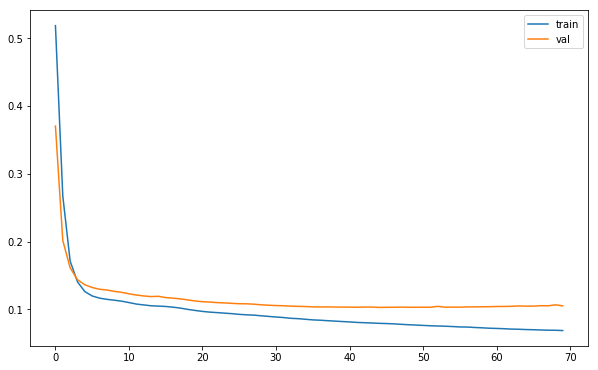

Early stopping reached at epoch 71.
Best val_loss 0.1029.


In [7]:
np.random.seed(0)
torch.manual_seed(0)

n_users = x.shape[0]
n_movies = x.shape[1]

ae = MovieLensAutoencoder(n_users, n_movies, h_dim = 128, ls_dim = 64)
ae.fit(
    x, # Matriz de interacciones
    lr = 5e-4, # Learning rating
    val_frac = 0.2, # Porcentaje de validación que se usará
    n_epoch = 500, # Número máximo de epoch
    early_stopping = 25, # Si en 25 epoch la métrica de validación no mejora, deja de entrenar.
    loss_function = nn.BCELoss(), # Función de perdida binary cross entropy
    callbacks = [plot_callback] # Calback para que vaya pintando iterativamente el proceso de entrenamiento
)

Por último guardamos el modelo para poder posteriormente cargarlo y predecir.

In [8]:
torch.save(ae, model_path)